#### Import python libraries for processing
##### special mention for the Pillow (PIL) library which I feel is a boon in the era of image processing atleast for beginers like me

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt

np.random.seed(100)
LEVEL = 'level_3'

#### Image Processing - Level Basic & Effective
##### We are creating a function which will read all the images from the kaggle folder path. While reading the images we are also performing some image processing techniques on them. Some of the processing operations are possible after the image is flattended out, however doing it in a single block caters to our needs.

##### image.convert("L") - Converts any image of any color configuration to Monochrome, using an built-in function and conversion algorithm the pixels are mapped in the range of 0 to 255, 0 being dark/black and 255 being bright/white, you should get the idea from here as to why we are doing this. We are reducing the complex image to a more manageable format. 

##### Important Fact - If you stop your processing here ( image.convert("L") and try tuning your hyper parameter - you cannot acheive higher accuracy figures. I felt this boilerplate code is still primitive way of image processing and such a code ( like MP Neuron ) would love binaries. I would like to add a special mention for Shravan ( see Key mentions for more details ) for pointing this out during a discussion on slack, I wanted to binarize it and was trying image.convert("1") - this would convert the image to black & white -  0 or 1. But again, based on a fixed algorithm just the way "L" would. I tried this option, but the accuracy and the log loss curve did not match my expectations and I did go ahead with it. You can try this and see for yourself. There may be a better way of using image.convert("1") and acheving good results. Now le's move on to Binarization of the pixels.

##### image.point - I came across this awesome pillow feature which would convert pixel range to binary using a threshold value. To be honest, this is not widely used because there are better ways of doing it using openCV ( I have explored this option but decided not to use it in the spirit of the contest and learning curve, there are lot of new users in this program who are new to image processing and openCV can be overwhelming, however I highly encourage everyone to look at openCV - any learning is good learning !! ). Coming to image.point, this according to me is probably the best way of binarizing the code if that is your main intention and the most easiest of all. A single line of code with lambda function ( thought to us in MP Neuron ) did the trick for me. There are several ways in which you can use this feature and set the threshold, I decided to go with my own way of setting the threshold as 15.

##### Why 15 ? - I wanted the text ( which we know is in range of black color pixels ) to stand out and I did account for the edges of the text ( if handwritten ). After some iterations of threshold value I decided to go with 15. Epochs and learning rate will have to adjusted to acheive high accuracy with other threshold values. After the lambda conversion, the text would now have value of 1 for pixel value <15 ( though not pure black, atleast it would stand out as black and I am having a range for black as 0 to 15 ) and anything that is not a text or any other color format from 16 to 255 would be 0 ( pure white - this has no range ! )

##### flatten() - This actually converts the image to an array of numbers. Remember - an image is nothing but numbers eventually !!

In [2]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        image = image.convert("L")
        image = image.point(lambda x: 1 if x<= 15 else 0)
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [3]:
languages = ['ta', 'hi', 'en']

images_train = read_all("../input/level_3_train/"+LEVEL+"/"+"background", key_prefix='bgr_') # change the path
for language in languages:
  images_train.update(read_all("../input/level_3_train/"+LEVEL+"/"+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all("../input/level_3_test/kaggle_"+LEVEL, key_prefix='') # change the path
print(len(images_test))

Reading:



Reading:



Reading:



Reading:



9000
Reading:



3000


#### A glimpse of images_train dictionary after IP
##### I am only displaying the bgr_ files for reference, please try modifying the code and view the images that contain the text.

In [4]:
first10values = {k: images_train[k] for k in sorted(images_train.keys())[:10]}
first10values

{'bgr_displayPanel_0_flip_blur': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'bgr_displayPanel_0_flip_blur_d2': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'bgr_displayPanel_0_flip_blur_d3': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'bgr_displayPanel_0_flip_edgeEnhance': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'bgr_displayPanel_0_flip_edgeEnhance_d2': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'bgr_displayPanel_0_flip_edgeEnhance_d3': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'bgr_displayPanel_0_flip_sharpen': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'bgr_displayPanel_0_flip_sharpen_d2': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'bgr_displayPanel_0_flip_sharpen_d3': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'bgr_displayPanel_0_flip_smooth': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)}

In [5]:
list(images_test.keys())[:5]

['2562', '2864', '1441', '2051', '1111']

#### Setting the X_train and Y_train values

##### Printing the X_train, Y_train and X_test sizes. Y_test wil be eventually predicted

In [6]:
X_train = []
Y_train = []
for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)
  
        
X_train = np.array(X_train) 
Y_train = np.array(Y_train) 
X_test = np.array(X_test) 

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(9000, 4096) (9000,)
(3000, 4096)


#### Eliminating StandardScaler
##### Now that we have converted the image to a binary format, we don't need StandardScaler. If this step is retained you will have variations in loss and accuracy as the conversion would tamper with the number of 1's present in the image. It's mandatory to remove this from the boilterplate if you are using standard binarization

In [7]:
#scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
#X_scaled_train = scaler.fit_transform(X_train)
#X_scaled_test = scaler.transform(X_test)

#### MSE
##### MSE is not meant for non linear datapoints, hence removed.

In [8]:
#sn_mse = SigmoidNeuron()
#sn_mse.fit(X_scaled_train, Y_train, epochs=1000, learning_rate=0.015, loss_fn="mse", display_loss=True)
#X_scaled_train

#### The SigmoidNeuron Class

In [9]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

#### Fit using Cross Entropy

##### An important thing to note here would be the epochs and learning rate. 

##### Learning Rate : Anything less than 0.00001 would result in a noisy loss curve because of overfitting. The model would be confused if the image is a text or not and your accuracy ( though high in some cases ) will not be generatlized across train and test. The trick here is to set the learning rate to a very low value to get a smooth loss curve as shown below

##### Epochs : A low epoch number results in a low train accuracy. You can try to work this on your own and see for yourself. You will have to cut a balance between train and test accuracy so that the model can be generalized for any data and should have low varience

##### The only downside of this code is the run time. Since there is no scaling the epochs seem to be running at a lower rate. With this combination the run time is about 1 Hour. Hence patience and learning is the key

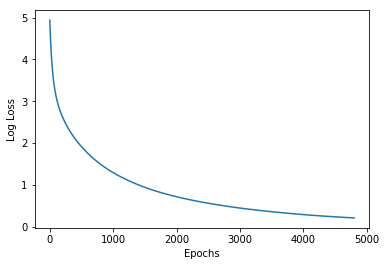

In [10]:
sn_ce = SigmoidNeuron()
#Scaling has been removed to acheive better accuracy
#sn_ce.fit(X_scaled_train, Y_train, epochs=800, learning_rate=0.00001, loss_fn="ce", display_loss=True)
sn_ce.fit(X_train, Y_train, epochs=4800, learning_rate=0.00001, loss_fn="ce", display_loss=True)

#### Print CE Accuracy

In [11]:
def print_accuracy(sn):
  Y_pred_train = sn.predict(X_train)
  Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
  print("Train Accuracy : ", accuracy_train)
  print("-"*50)

In [12]:
#print_accuracy(sn_mse)
print_accuracy(sn_ce)

Train Accuracy :  0.9521111111111111
--------------------------------------------------


In [13]:
Y_pred_test = sn_ce.predict(X_test)
Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()

submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_binarised_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submisision.csv", index=False)

### Acheivements

##### 1. The above logic has worked best for me resulting in a train accuracy of **95.21%** and a test accuracy of **84.55 %** on **29%** of the data followed by **85.04 %** on **71% **of the data.
##### 2. I feel the model is consistent and will not vary over a varience of **10%** which is my cut off for accuracy on any given dataset which is able to fit into the model
##### 3. Basic & effective tool kit used to acheive high accuracy and acheived a better understanding in image processing techniques
##### 4. Kaggle rank **26** out of **442** ( **Top 6%** )

### Key Mentions & References

##### 1. The entire team of https://padhai.onefourthlabs.in for their supreme training efforts, dedication, data cleansing and quality time in helping the newbies and pros scale higher in their pursuit of becoming a better data scientist  
##### 2. https://www.stackoverflow.com - for most of the doubts, errors & shortcuts in python 
##### 3. My Ex Manager & Mentor for life, Arulvel Kumar - https://au.linkedin.com/in/arulvel-kumar who has been a great motivation and driving force of my data science career. 
##### 4. Shravan Kumar Koninti - https://in.linkedin.com/in/shravan-kumar-a8223023